# Preparing dataset

In [2]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json',precise_float='true')

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')

# Inspect the resultant dataframe
echo_tracks.info(verbose=None,buf=None,max_cols=None,memory_usage=None,null_counts=None)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


# Pairwise relationships between continuous variables


In [3]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr(method='pearson', min_periods=1)
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


#  Normalizing the feature data

In [4]:
# Define our features 
features=echo_tracks.drop(columns=['genre_top','track_id'])

# Define our labels
labels = echo_tracks.loc[:,'genre_top']



# Import the StandardScaler
import sklearn.preprocessing as sk

# Scale the features and set the values to a new variable
scaler = sk.StandardScaler(copy=True,with_mean=True,with_std=True)
scaled_train_features = scaler.fit_transform(features)

# Principal Component Analysis on our scaled data

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]
8


Text(0.5,0,'Principal Component #')

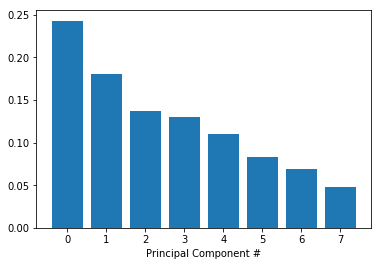

In [5]:
# This is just to make plots appear in the notebook
%matplotlib inline


# Import our plotting module, and PCA class

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca=PCA()

pca.fit(scaled_train_features)
exp_variance=pca.explained_variance_ratio_
print(exp_variance)
print(pca.n_components_)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(8), exp_variance)
ax.set_xlabel('Principal Component #')

# Further visualization of PCA

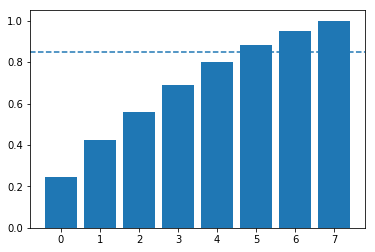

In [6]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.bar(range(8), cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

# Train a decision tree to classify genre

In [7]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels,random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10) 
tree.fit(train_features,train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

# Compare our decision tree to a logistic regression

In [8]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)

pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.66      0.66      0.66       229
       Rock       0.92      0.92      0.92       972

avg / total       0.87      0.87      0.87      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.57      0.65       229
       Rock       0.90      0.95      0.93       972

avg / total       0.87      0.88      0.87      1201



# Balance our data for greater performance

In [9]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks["genre_top"]=="Hip-Hop"]


# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"].sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels, random_state=10)

# Does balancing our dataset improve model bias?

In [10]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.77      0.77      0.77       230
       Rock       0.76      0.76      0.76       225

avg / total       0.76      0.76      0.76       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.82      0.83      0.82       230
       Rock       0.82      0.81      0.82       225

avg / total       0.82      0.82      0.82       455



# Using cross-validation to evaluate our models

In [11]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree,pca_projection,labels,cv=kf)
logit_score = cross_val_score(logreg,pca_projection,labels,cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score),"Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7241758241758242 Logistic Regression: 0.7752747252747252
